In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!pip install -q SentencePiece transformers[sentencepiece]
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 8.7 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86831 sha256=a05dd974edf54266252bd63c35204b075485c8beba1104afedb4598a9cdf8277
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [7]:
import torch
from transformers import T5EncoderModel, T5Tokenizer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import re
import numpy as np
import pandas as pd
import pickle
import gc
import umap

In [13]:
dataset = pd.read_csv('/content/drive/MyDrive/TCREpitopePairs.csv')
dataset.head(5)

,epi,tcr,binding
0,EAAGIGILTV,CASSLGNEQF,1
1,EAAGIGILTV,CASSLGVATGELF,1
2,EAAGIGILTV,CASSQEEGGGSWGNTIYF,1
3,EAAGIGILTV,CASSQEGLAGASQYF,1
4,EAAGIGILTV,CASSQETDIVFNOPQHF,1


# Output Fine-tuned Embeddings

In [5]:
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False )

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [6]:
!gsutil -m cp -r "gs://tcrcheckpoints/checkpoint-50000" .

Copying gs://tcrcheckpoints/checkpoint-50000/config.json...
Copying gs://tcrcheckpoints/checkpoint-50000/global_step50000/zero_pp_rank_0_mp_rank_00_optim_states.pt...
Copying gs://tcrcheckpoints/checkpoint-50000/latest...
Copying gs://tcrcheckpoints/checkpoint-50000/spiece.model...
Copying gs://tcrcheckpoints/checkpoint-50000/global_step50000/mp_rank_00_model_states.pt...
Copying gs://tcrcheckpoints/checkpoint-50000/rng_state.pth...
Copying gs://tcrcheckpoints/checkpoint-50000/pytorch_model.bin...
Copying gs://tcrcheckpoints/checkpoint-50000/special_tokens_map.json...
Copying gs://tcrcheckpoints/checkpoint-50000/tokenizer_config.json...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

Copying gs://tcrcheckpoints/checkpoint-50000/trainer_state.json...
Copying gs://tcrcheckpoints/checkpoint-5000

In [7]:
model = T5EncoderModel.from_pretrained("checkpoint-50000/")
gc.collect()

67

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
model = model.eval()

In [ ]:
sequences = list(dataset["CDR3.beta.aa"])
sequences = [str(s) for s in sequences]
sequences = [re.sub(r"[UZOBX]", "<unk>", sequence) for sequence in sequences]
sequences = [" ".join(s) for s in sequences]
features = []
batchsize = 10**3
currIndex = 0
while currIndex < len(sequences):
  #print(f"{currIndex}/{len(sequences)}")
  ids = tokenizer.batch_encode_plus(sequences[currIndex:currIndex+batchsize], add_special_tokens=True, padding=True)
  input_ids = torch.tensor(ids['input_ids']).to(device)
  attention_mask = torch.tensor(ids['attention_mask']).to(device)
  with torch.no_grad():
      embedding = model(input_ids=input_ids,attention_mask=attention_mask)
  embedding = embedding.last_hidden_state.cpu().numpy()
  for seq_num in range(len(embedding)):
      seq_len = (attention_mask[seq_num] == 1).sum()
      seq_emd = embedding[seq_num][:seq_len-1]
      seq_emd = np.mean(seq_emd, axis=0)
      features.append(seq_emd)
  currIndex += batchsize

In [17]:
#with open('/content/drive/MyDrive/Elmo_Embeddings_FineTuned.pkl', 'wb') as f:
#  pickle.dump(features, f)
with open('Elmo_Embeddings_FineTuned.pkl', 'wb') as f:
  pickle.dump(features, f)

# Plot Fine-tuned Embeddings

In [15]:
with open('/content/drive/MyDrive/Elmo_Embeddings_FineTuned.pkl', 'rb') as f:
    features = pickle.load(f)

In [12]:
tickle_me_elmos = ["VQELYSPIFLIV", "MIELSLIDFYLCFLAFLLFLVLIML", "LSPRWYFYYL",
                   "GILGFVFTL", "LLWNGPMAV"]

In [16]:
indices_top5 = list(dataset['epi'].isin(tickle_me_elmos))
features_elmo = np.array(features)[indices_top5]

In [17]:
reducer = umap.UMAP(random_state=42)
reducer.fit(np.array(features_elmo))
umap_embedding = reducer.transform(np.array(features_elmo))

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [18]:
pca = PCA(n_components=50)
pca_result = pca.fit_transform(features_elmo)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.14521267 0.0952988  0.07601196 0.06651868 0.05461751 0.04441847
 0.03796395 0.03707569 0.03013657 0.02698177 0.02350958 0.02027145
 0.01808281 0.01664241 0.01475098 0.01309651 0.01214469 0.01096473
 0.00960017 0.00912969 0.00870603 0.00817767 0.00669455 0.0062546
 0.00595032 0.00551985 0.00519184 0.00498644 0.00468181 0.00429149
 0.00406066 0.00386078 0.00368098 0.00346053 0.00339464 0.00309412
 0.00300645 0.00279085 0.00267481 0.00258409 0.00243952 0.00242316
 0.00219549 0.00216553 0.00206428 0.00204166 0.0020059  0.00191402
 0.00184827 0.00180108]


In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(pca_result)

In [20]:
epis = np.array(dataset["epi"])[indices_top5]
bindings = np.array(dataset["binding"])[indices_top5]

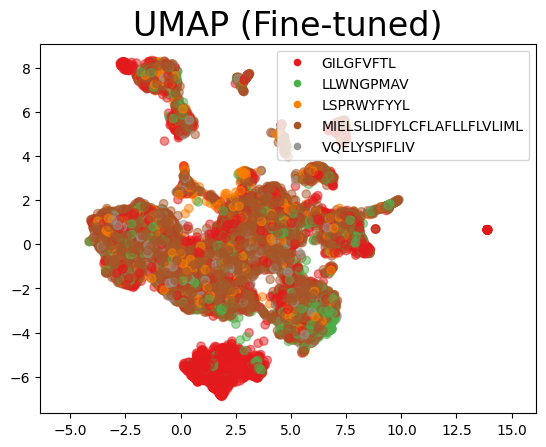

In [22]:
import matplotlib.pyplot as plt
def plotter(projections, epis, bindings, title, size=30):
  unique_epis = list(np.unique(epis))
  colors = np.array([unique_epis.index(d) for d in epis])

  # Change color based on embeddings
  colors = np.array([colors[i] if bindings[i] == 1 else len(unique_epis) for i in range(len(colors))])
  unique_epis.append("Non-binding")

  # Filter based on embedding
  colors = colors[bindings == 1]
  projections = projections[bindings==1]

  perm = np.random.permutation(len(colors))

  sc = plt.scatter(projections[:, 0][perm], projections[:, 1][perm], alpha=.5,
                  c = colors[perm], cmap = 'Set1')
  lp = lambda i: plt.plot([],color=sc.cmap(sc.norm(i)), ms=np.sqrt(size), mec="none",
                          label=unique_epis[i].format(i), ls="", marker="o")[0]
  handles = [lp(i) for i in np.unique(colors)]
  plt.legend(handles=handles)
  plt.gca().set_aspect('equal', 'datalim')
  plt.title(title, fontsize=24);
plotter(umap_embedding, epis, bindings, "UMAP (Fine-tuned)")

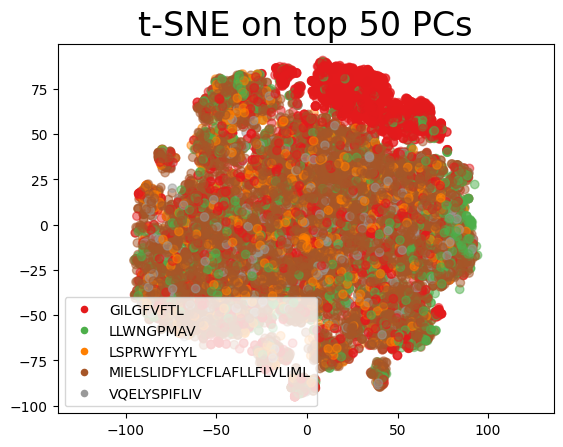

In [56]:
plotter(tsne_results, epis, bindings, "t-SNE (Finetuned)")

# Output Non-Finetuned Embeddings

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False )
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")
gc.collect()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model = model.eval()

In [ ]:
sequences = list(dataset["CDR3.beta.aa"])
sequences = [str(s) for s in sequences]
sequences = [re.sub(r"[UZOBX]", "<unk>", sequence) for sequence in sequences]
sequences = [" ".join(s) for s in sequences]
features_p5 = []
batchsize = 10**3
currIndex = 0
while currIndex < len(sequences):
  #print(f"{currIndex}/{len(sequences)}")
  ids = tokenizer.batch_encode_plus(sequences[currIndex:currIndex+batchsize], add_special_tokens=True, padding=True)
  input_ids = torch.tensor(ids['input_ids']).to(device)
  attention_mask = torch.tensor(ids['attention_mask']).to(device)
  with torch.no_grad():
      embedding = model(input_ids=input_ids,attention_mask=attention_mask)
  embedding = embedding.last_hidden_state.cpu().numpy()
  for seq_num in range(len(embedding)):
      seq_len = (attention_mask[seq_num] == 1).sum()
      seq_emd = embedding[seq_num][:seq_len-1]
      seq_emd = np.mean(seq_emd, axis=0)
      features_p5.append(seq_emd)
  currIndex += batchsize

# Plot Non-Finetuned

In [57]:
#features_p5 = np.load('/content/drive/MyDrive/tcr_embeddings_no_finetune.npy')
features_p5_elmo = np.array(features_p5)[indices_top5]

In [59]:
import umap
reducer = umap.UMAP(random_state=42)
reducer.fit(np.array(features_p5_elmo))
umap_p5_embedding = reducer.transform(np.array(features_p5_elmo))

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [60]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
pca = PCA(n_components=50)
pca_p5_result = pca.fit_transform(features_p5_elmo)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.10080829 0.08596563 0.0641815  0.06385171 0.05170923 0.04306479
 0.03932379 0.03728613 0.03361915 0.02606632 0.02426741 0.02264624
 0.0196721  0.01801777 0.01519614 0.01390101 0.01191454 0.01125815
 0.01075055 0.00971103 0.00954835 0.00874131 0.00756919 0.00710363
 0.00653806 0.00593412 0.00578522 0.00505493 0.00501866 0.00495672
 0.00442655 0.00409103 0.00392835 0.00375802 0.00361929 0.00360736
 0.00340897 0.00336788 0.00320746 0.00301758 0.00300814 0.00281384
 0.00270825 0.00264294 0.00248047 0.00240708 0.0023936  0.00230277
 0.00223261 0.00214097]


In [ ]:
tsne_p5_results = tsne.fit_transform(pca_p5_result)

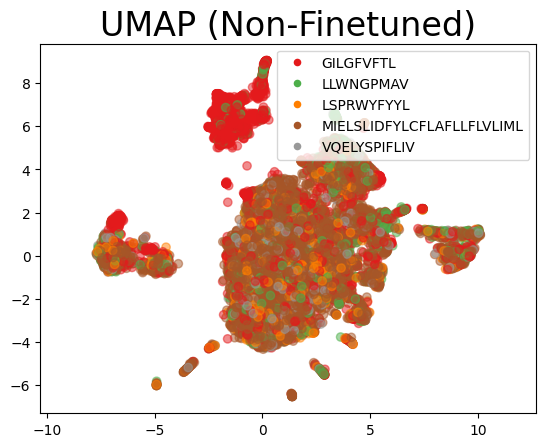

In [63]:
plotter(umap_p5_embedding, epis, bindings, "UMAP (Non-Finetuned)")

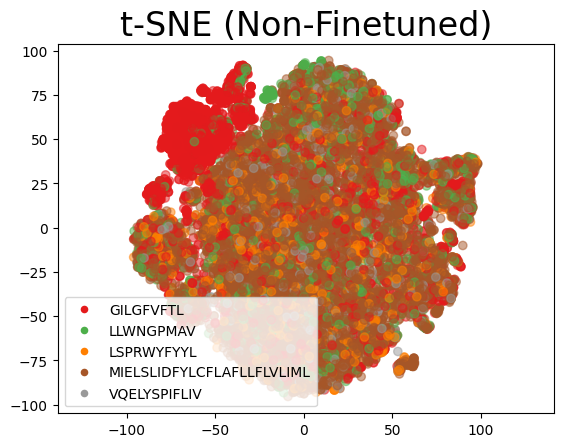

In [64]:
plotter(tsne_p5_results, epis, bindings, "t-SNE (Non-Finetuned)")